In [2]:
#basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression    
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
df = pd.read_csv('data/DJIA_table.csv')

In [4]:
df['Close']

0       17949.369141
1       17929.990234
2       17694.679688
3       17409.720703
4       17140.240234
            ...     
1984    11615.929688
1985    11532.959961
1986    11642.469727
1987    11782.349609
1988    11734.320312
Name: Close, Length: 1989, dtype: float64

In [5]:
#Create a data-set with Date: Last 5 close prices, Last 5 Volume
# Also a Predicted Y label 

In [9]:
#creating samples from the testing/training dataset
def create_dataset(df, window=10, op_size=1):
    x = []
    y = []
    z =  []
   # print("Window size : ", window)
    for i in range(window, df.shape[0]-op_size):
        x.append(df[i-window:i, 0])
        y.append(df[i:i+op_size, 0])             
        if df[i+1,0]-df[i,0] > 0 :
            z.append(1)
        else:
            z.append(0)
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)    
    return x,y,z

In [12]:
train_percentages=[0.1,0.3,0.5,0.7,0.8]
window_sizes = [1,3,5,10]

#train_percentages=[0.1]
#window_sizes = [10]
results={}


for train_per in train_percentages:    
    
    dClose = df['Close'].values
    dClose = dClose.reshape(-1, 1)
        
    for window in window_sizes:
        print('Processing ',train_per,window)
        
        #print(dataset_train.shape)
        #print(dataset_test.shape)

        dataset_train = np.array(dClose[:int(dClose.shape[0]*train_per)])
        dataset_test = np.array(dClose[int(dClose.shape[0]*train_per)-window:])

        min_max_scaler = MinMaxScaler(feature_range=(0,1))
        dataset_train = min_max_scaler.fit_transform(dataset_train)
        dataset_test = min_max_scaler.transform(dataset_test)

        x_train, y_train, z_train = create_dataset(dataset_train,window,1)
        x_test, y_test, z_test = create_dataset(dataset_test,window,1)
        clf = LogisticRegression(random_state=0).fit(x_train, z_train)        
        z_test_pred=clf.predict(x_test)
        reg = LinearRegression().fit(x_train, y_train)                
        y_test_pred=reg.predict(x_test)    
        
        zz_test_pred=[]

       

        zz_test_pred.append(1)            
        for i in range(1,y_test_pred.shape[0]):    
            if y_test_pred[i] - y_test_pred[i-1] > 0 :
                    zz_test_pred.append(1)
            else:
                    zz_test_pred.append(0)

        

        zz_test_pred_arr    = np.array(zz_test_pred)

        
        data=[y_test_pred,z_test_pred,
              reg.score(x_test,y_test),
              mean_squared_error(y_test, y_test_pred),              
              clf.score(x_test,z_test),
              mean_squared_error(z_test, z_test_pred),       
              mean_squared_error(z_test, zz_test_pred),       
              r2_score(z_test, zz_test_pred)
             ]
        
        if train_per in list(results.keys()):
                mapTrainingPer = results[train_per]
                mapTrainingPer.update({window:data})
                    
        else:
            mapTrainingPer = {}
            mapTrainingPer.update({window:data})
            results.update({train_per:mapTrainingPer})
        
        
        
        

Processing  0.1 1
Processing  0.1 3
Processing  0.1 5
Processing  0.1 10
Processing  0.3 1
Processing  0.3 3
Processing  0.3 5
Processing  0.3 10
Processing  0.5 1
Processing  0.5 3
Processing  0.5 5
Processing  0.5 10
Processing  0.7 1
Processing  0.7 3
Processing  0.7 5
Processing  0.7 10
Processing  0.8 1
Processing  0.8 3
Processing  0.8 5
Processing  0.8 10


In [13]:
for train_per in results.keys():
    for window in results[train_per].keys():
        data=results[train_per][window]
        print('Train per:',train_per,'Window size:', window, '\nRegression score', data[2],
              'MSE', data[3],
              '\nLogistic Reg score',data[4],
               'LR MSE ', data[5],
               '\n Regression for classification MSE, score ', data[6], data[7]
             )    
        print('========================')
        #dClose = df['Close'].values
        #dClose = dClose.reshape(-1, 1)
        #dataset_train = np.array(dClose[:int(dClose.shape[0]*train_per)])
        #dataset_test = np.array(dClose[int(dClose.shape[0]*train_per)-window:])
        
        #min_max_scaler = MinMaxScaler(feature_range=(0,1))
        #dataset_train = min_max_scaler.fit_transform(dataset_train)
        #dataset_test = min_max_scaler.transform(dataset_test)
        #x_test, y_test, z_test = create_dataset(dataset_test,window,1)
        #labelW= "prediction "+ str(train_per)+" "+str(window)
        #fig, ax = plt.subplots(figsize=(5, 2.7))
        #ax.plot(np.arange(len(y_test)), y_test, label='train')
        #ax.plot(np.arange(len(data[0])), data[0], label=labelW)
        #ax.legend();

Train per: 0.1 Window size: 1 
Regression score 0.9954010552854513 MSE 0.00709144609164894 
Logistic Reg score 0.482122905027933 LR MSE  0.517877094972067 
 Regression for classification MSE, score  0.4949720670391061 -0.9900643595602625
Train per: 0.1 Window size: 3 
Regression score 0.9962161416291826 MSE 0.005834605397668768 
Logistic Reg score 0.48044692737430167 LR MSE  0.5195530726256983 
 Regression for classification MSE, score  0.49273743016759775 -0.9810798703523154
Train per: 0.1 Window size: 5 
Regression score 0.9960721084354152 MSE 0.006056700615682293 
Logistic Reg score 0.4810055865921788 LR MSE  0.5189944134078213 
 Regression for classification MSE, score  0.49385474860335193 -0.985572114956289
Train per: 0.1 Window size: 10 
Regression score 0.9952632265365208 MSE 0.007303974226598853 
Logistic Reg score 0.4798882681564246 LR MSE  0.5201117318435754 
 Regression for classification MSE, score  0.49329608938547487 -0.9833259926543021
Train per: 0.3 Window size: 1 
Regr

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [15]:
output_size=1
window_size=10
x_train, y_train, z_train = create_dataset(dataset_train, window=window_size, op_size=output_size)
x_test, y_test, z_test = create_dataset(dataset_test, window=window_size, op_size=output_size)

#building the model
model = Sequential()
model.add(Dense(window_size, activation='relu', input_shape=(window_size,)))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
#model.add(Dense(10, activation='relu'))
#model.add(Dense(output_size))
model.add(Dense(output_size, activation='sigmoid'))
#model.add(Dense(window_size, activation='relu', input_shape=(window_size,)))
#model.add(Dense(30, activation='relu'))
#model.add(Dense(output_size, activation='sigmoid'))
model.compile(optimizer='adam', loss='mean_squared_error')
#training the model
#history = model.fit(x_train, y_train, epochs=50, batch_size = 2)
history = model.fit(x_train, y_train, validation_split=0.15, epochs=200, batch_size=2, verbose=0,shuffle=False)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                110       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________
None


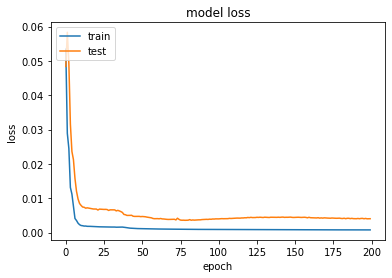

In [16]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()